In [1]:
import operator
from random import random


def length_check(func):
    def wrapper(*args, **kwargs):
        if not isinstance(args[1], Vector):  # Vector +-/* int or float
            return func(*args, **kwargs)

        if len(args[0]) != len(args[1]):
            raise Exception(f"Tried to perform operator on differing length vectors ({args[0]}, {args[1]}).")
        
        return func(*args, **kwargs)
    return wrapper

class Vector:
    __slots__ = ['values', '_len']

    def __init__(self, values: list):
        self.values = values
        self._len = len(values)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, i) -> int | float:
        return self.values[i]

    def __iter__(self):
        return self.values.__iter__()

    def transpose(self):
        a = Matrix([[x] for x in self.values])
        return a

    def copy(self) -> "Vector":
        return Vector(self.values)
    
    @staticmethod
    def random(length: int) -> "Vector":
        return Vector([random() for _ in range(length)])
        # return Vector([random() for _ in range(length)])

    def dotprod(self, other) -> int:
        if len(self) == 1:
            return other * self[0]  # Handling it as matrix multiplication.

        if len(self) != len(other):
            raise Exception(f"Tried to perform operator on differing length vectors ({self}, {other}).")

        return sum(self[i] * other[i] for i in range(len(self)))

    @length_check
    def crossprod(self, other) -> "Vector":
        if len(self) != 3:
            raise Exception("Cross products are only implemented for the case of len 3.")

        return Vector([self[1] * other[2] - self[2] * other[1],
                       self[2] * other[0] - self[0] * other[2],
                       self[0] * other[1] - self[1] * other[0]])

    def unwrap(self) -> float | int:
        if len(self) > 1:
            raise Exception("Tried to unwrap vector of length", len(self))

        return self[0]

    @length_check
    def _element_wise_operation(self, other, operand) -> "Vector":
        if isinstance(other, Vector):
            return Vector([operand(self[i], other[i]) for i in range(len(self))])

        return Vector([operand(x, other) for x in self])

    def __add__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.add)

    def __radd__(self, other):
        return self + other

    def __sub__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.sub)

    def __rsub__(self, other):
        return self - other

    def __truediv__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.truediv)

    def __rtruediv__(self, other):
        return self / other

    def __mul__(self, other) -> "Vector":
        if isinstance(other, Vector):
            return self.dotprod(other)
        if isinstance(other, Matrix):
            return NotImplemented

        return Vector([x * other for x in self])  # Fixed multiplication with scalar
    
    def __rmul__(self, other):
        return self * other

    def __repr__(self):
        return str(self.values)

    def hadamard(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.mul)


def shape_check(func):
    def wrapper(*args, **kwargs):
        if not isinstance(args[1], Matrix):  # Vector +-/* int or float
            return func(*args, **kwargs)

        if args[0].shape != args[1].shape:
            raise Exception(f"Tried to get the dot product of differently shaped matrices ({args[0].shape, args[1].shape}).")
        
        return func(*args, **kwargs)
    return wrapper


def matrix_mul(self, other):  # Kinda messy, but better than duplication for edgecases with __rmul__().
    if not isinstance(other, Matrix):
        return Matrix([x * other for x in self])

    if self.shape[0] != other.shape[1]:
        raise Exception(f"Tried to multiply matrices of unsupported shapes ({self.shape}, {other.shape})")

    other_tp = other.transpose()
    return Matrix([[x.dotprod(y) for y in other_tp] for x in self])


# IMPORTANT: values is a list of rows, so len(val) = n_rows and len(val[0]) = n_cols.
class Matrix:
    __slots__ = ['values', 'shape']

    def __new__(cls, values):  # 1 row matrix -> vector coercion.
        if len(values) == 1:
            return Vector(values[0])
        return super().__new__(cls)
        
    def __init__(self, values):
        if any(len(values[0]) != len(values[i]) for i in range(1, len(values))):
            raise ValueError(f"Mismatching rows lengths for matrix ({[len(x) for x in values]}).")
        self.values = [Vector(row) if not isinstance(row, Vector) else row for row in values]
        self.shape = (len(self.values), len(values[0]))

    def __getitem__(self, i) -> Vector:
        return self.values[i]

    def __iter__(self):
        return self.values.__iter__()
    @staticmethod
    def random(n_rows: int, n_cols) -> "Vector":
        return Matrix([[0 for _ in range(n_cols)] for _ in range(n_rows)])

    def copy(self) -> "Matrix":
        return Matrix(*[x.copy() for x in self])

    def transpose(self) -> "Matrix":
        return Matrix([list(x) for x in zip(*self)])
    
    def determinant(self) -> float:
        n_rows, n_cols = self.shape

        if n_rows != n_cols:
            raise Exception("Determinants are only supported for square matrices.")
            
        if n_rows == 1:
            return self[0][0]
        if n_rows == 2:
            return self[0][0] * self[1][1] - self[0][1] * self[1][0]
        
        # Laplace expansion along first row.
        def cofactor(j: int) -> float | int:
            # Excluding first row and current column.
            minor = [[self[i][k] for k in range(n_cols) if k != j] 
                     for i in range(1, n_rows)]

            return self[0][j] * ((-1) ** j) * Matrix(minor).determinant()
        
        return sum(cofactor(j) for j in range(n_cols))

    @shape_check
    def _element_wise_operation(self, other, operand) -> "Matrix":
        if isinstance(other, Matrix):
            return Matrix([operand(self[i], other[i]) for i in range(self.shape[0])])
                         
        return Matrix([operand(x, other) for x in self])

    def __add__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.add)

    def __radd__(self, other):
        return self + other

    @shape_check
    def __truediv__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.truediv)

    def __rtruediv__(self, other):
        return self / other

    @shape_check
    def __sub__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.sub)

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        if isinstance(other, Vector):  # Treat as row vector
            return Matrix([Vector([row.unwrap() * x for x in other]) for row in self])

            # Treat vector as column vector (Nx1)
            if self.shape[1] != len(other):
                raise Exception(f"Incompatible shapes for matrix-vector multiplication: {self.shape} and {len(other)}")
            return Vector([row.dotprod(other) for row in self])
        return matrix_mul(self, other)

    def __rmul__(self, other):
        if isinstance(other, Vector):
            # Treat vector as 1xN matrix multiplying an NxM matrix
            return Vector([sum(other[i] * self[i][j] for i in range(len(other))) 
                          for j in range(len(self[0]))])
        return matrix_mul(other, self)

    def __repr__(self):
        return "\n".join(str(x) for x in self)

    def hadamard(self, other) -> "Matrix":
        return self._element_wise_operation(self, other, operator.mul)

In [2]:
from functools import reduce
import operator
from random import random, shuffle

from tensors import Matrix, Vector


class Function:
    def __init__(self, name: str, func: callable, derivative: callable):
        self.name = name
        self.func = func
        self.deriv = derivative

    def compute(self, data: Vector) -> Vector:
        return Vector([self.func(x) for x in data])

    def compute_deriv(self, data: Vector) -> Vector:
        return Vector([self.deriv(x) for x in data])


class ANN:
    def __init__(self, layer_sizes: list[int], activation_funcs: list[Function], alpha: float, endlabels: list = None):
        self.weights = [Matrix.random(x, y) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [Vector.random(x) for x in layer_sizes[1:]]
        self.activation_funcs = activation_funcs

        self.alpha = alpha

        self.last_run_z = None  # Saved for backprop.
        self.last_run_A = None  # Saved for backprop.
        self.MSEs = None

        self._epoch_counter = 0

        self.endlabels = endlabels
        if endlabels and len(endlabels) != layer_sizes[-1]:
            raise Exception("Number of endlabels doesn't match length of output layer.")

    def __repr__(self):
        weights_str = "\n".join(f"{w}\n" for w in self.weights)
        biases_str = "\n".join(f"{b}\n" for b in self.biases)
        return f"Weights:\n{weights_str}\n\nBiases:\n{biases_str}\n"

    def train(self, features: list[Vector], labels: list[Vector], interval_k: int = 1000) -> dict:
        self.MSEs = []

        n = len(features)
        for f, l in zip(features, labels):
            _ = self.predict(f)

            self.correct(l, n)
            self._epoch_counter += 1

            if self._epoch_counter % interval_k == 0:
                print(f"Training at {self._epoch_counter} epochs.")

    def predict(self, features: Vector) -> list | dict:
        self.last_run_z = []
        self.last_run_A = []
        z = features

        for weights, biases, activ, in zip(self.weights, self.biases, self.activation_funcs):
            A = activ.compute(z)
            z = A * weights + biases
            self.last_run_A.append(A)
            self.last_run_z.append(z)

        A = self.activation_funcs[-1].compute(z)  # TODO: Better loop so this last case doesn't have to be excluded.
        self.last_run_A.append(A)

        return dict(zip(self.endlabels, A)) if self.endlabels else A

    def correct(self, labels: Vector, n: int):
        # Start with output layer error
        e = self.last_run_A[-1] - labels
        self.MSEs.append((e * e.transpose() / n).unwrap())

        z_partials = [e]  # z_L = A_L - Y

        # Compute z_partials backwards through layers
        for i in range(len(self.weights) - 1, 0, -1):  # Go from L-1 to 1
            z = self.last_run_z[i - 1]  # Get z for current layer
            weights = self.weights[i]  # Get weights for next layer
            activ = self.activation_funcs[i]  # Get activation for current layer

            # Calculate partial using the formula: (∂z_{l+1} · W_{l+1}^T) ⊙ f'(z_l)
            z_partial = (z_partials[-1] * weights.transpose()).hadamard(activ.compute_deriv(z))
            z_partials.append(z_partial)

        z_partials = list(reversed(z_partials))

        # Calculate weight partials using A_{l-1}^T · ∂z_l
        w_partials = [A.transpose() * z_p / n for A, z_p in zip(self.last_run_A, z_partials)]

        # Calculate bias partials
        b_partials = [z / n for z in z_partials]

        # Update weights and biases
        self.weights = [w - w_p * self.alpha for w, w_p in zip(self.weights, w_partials)]
        self.biases = [b - b_p * self.alpha for b, b_p in zip(self.biases, b_partials)]

    def save_parameters(self, name: str):
        pass

In [3]:
ReLU = Function(name="ReLU",
                func=lambda x: x if x > 0 else 0,
                derivative=lambda x: int(x > 0))

e = 2.71828
sig = lambda x: 1 / (1 + e ** (-x))
Sigmoid = Function(name="Sigmoid",
                   func=sig,
                   derivative=lambda x: sig(x) * (1 - sig(x)))

Identity = Function(name="Identity",
                    func=lambda x: x,
                    derivative=lambda x: 1)

SCORE:1.744186%
SCORE:44.186047%
SCORE:48.837209%
SCORE:45.930233%


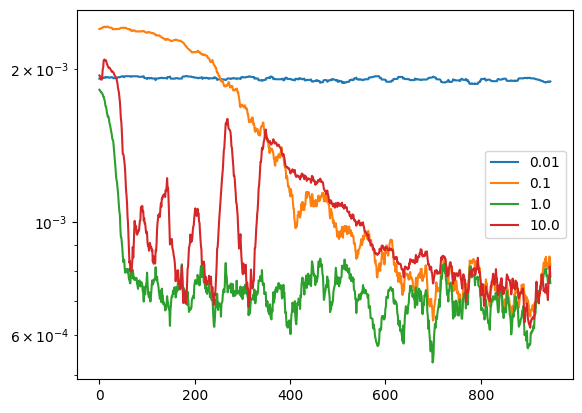

In [40]:
layer_sizes = [11, 11, 6]
activation_funcs = [Identity, ReLU, Sigmoid]
alpha = 0.16

# Load CSV
features, labels = [], []
qualities = list(range(3, 9))
with open('WineQT.csv', 'r') as f:
    for line in f.readlines()[1:]:
        *feat, label, _ = line.split(',')

        features.append(Vector([float(f) for f in feat]))
        labels.append(Vector([float(int(label) == q) for q in qualities]))

from sklearn.model_selection import train_test_split

training_features, testing_features, training_labels, testing_labels = train_test_split(features, labels,
                                                                                        random_state=1,
                                                                                        test_size=0.15,
                                                                                        shuffle=True)

epochs = {}

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


for alpha in (0.01, 0.1, 1, 10):
    nn = ANN(layer_sizes, activation_funcs, alpha, endlabels=qualities)
    nn.train(training_features, training_labels)
    
    def argmax_label(d: dict) -> str:
        # return the key of which the value is highest of all values
        return [label for label in d if d[label] == max(d.values())][0]
    
    
    correct = 0
    for f, l in zip(testing_features, testing_labels):
        output = nn.predict(f)
        pred = max(output.keys(), key=lambda k: output[k])
        label = float(max(range(3, 9), key=lambda x: l[x - 3]))
    
        correct += pred == label
    
    print(f"SCORE:{correct / len(testing_features) * 100:2f}%")
    
    epochs[alpha] = moving_average(nn.MSEs, 25)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.lineplot(epochs, dashes=False)

plt.yscale('log')
plt.show()

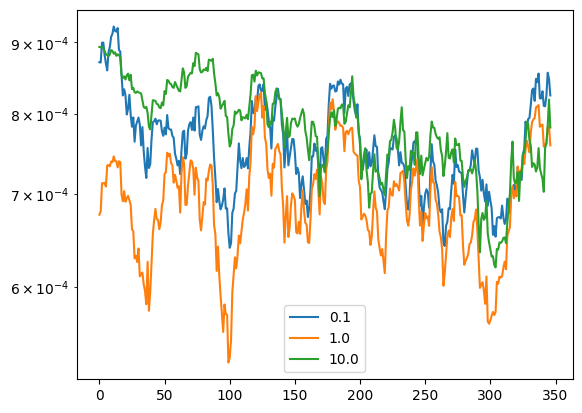

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.lineplot({k: v[600:] for k, v in epochs.items() if k != 0.01}, dashes=False)

plt.yscale('log')
plt.show()